In [25]:
from langchain.chat_models import init_chat_model
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [26]:
from dotenv import load_dotenv
load_dotenv()

True

In [27]:
# --- State definition ---
class State(TypedDict):
    # Conversation history. The `add_messages` annotation tells LangGraph to APPEND
    # messages instead of replacing them.
    messages: Annotated[list, add_messages]

In [28]:
# --- Tools (simple, deterministic) ---
@tool
def get_stock_price(symbol: str) -> float:
    """Return the current price of a stock given the stock symbol.
    :param symbol: stock symbol (e.g., 'AAPL')
    :return: current price of the stock
    """
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol.upper(), 0.0)

tools = [get_stock_price]

In [29]:
# --- LLM setup (bound to tools) ---
llm = init_chat_model("openai:gpt-5")
llm_with_tools = llm.bind_tools(tools)

In [23]:
# --- Nodes ---
def chatbot(state: State) -> State:
    reply = llm_with_tools.invoke(state["messages"])
    return {"messages": [reply]}



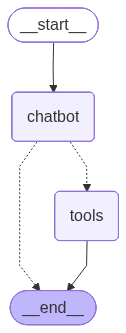

In [24]:
builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
state = graph.invoke({"messages": [{"role": "user", "content": "Give only the number: current price of MSFT?"}]})
print(state["messages"][-1].content)

200.3


In [21]:
state = graph.invoke({"messages": [{"role": "user", "content": "name first US president? print person name only"}]})
print(state["messages"][-1].content)

George Washington


In [22]:
msg = "Buy 20 AMZN and 15 MSFT at their current prices. Return only the total cost in USD (number)."

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3
